# Tutorial 5: Using the LDTk limb darkening model

**Author:** Hannu Parviainen <br>
**Edited:** 1 November 2024

In [1]:
%run ../setup_multiprocessing.py

In [2]:
%matplotlib inline

In [3]:
from multiprocessing import Pool
from xarray import load_dataset
from scipy.interpolate import splev, splrep
from numpy import array, geomspace, linspace
from matplotlib.pyplot import subplots, setp

from exoiris import ExoIris, TSData
from pytransit import LDTkLD
from ldtk import BoxcarFilter

## Data preparation

In [4]:
def read_data(fname, name=""):
    with load_dataset(fname) as ds:
        return TSData(time=ds.time.values, wavelength=ds.wavelength.values, fluxes=ds.flux.values, errors=ds.error.values, name=name)

d1 = read_data('data/nirHiss_order_1.h5', "WASP-39b JWST NIRISS Order 1")
d1.remove_outliers()
d1.mask_transit(t0=2459783.5015, p=4.0552842, t14=0.13)
d1.normalize_to_poly()

d2 = read_data('data/nirHiss_order_2.h5', "WASP-39b JWST NIRISS Order 2")
d2.remove_outliers()
d2.crop_wavelength(d2.wllims[0], 1.0)
d2.mask_transit(ephemeris=d1.ephemeris)
d2.normalize_to_poly()

TSData Name:'WASP-39b JWST NIRISS Order 2' [0.57 - 1.00] nwl=957 npt=518

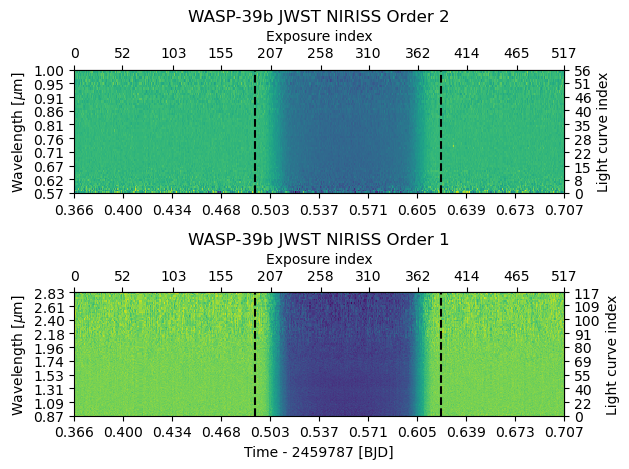

In [6]:
db = d2.bin_wavelength(r = 100) + d1.bin_wavelength(r = 100)
fig = db.plot()
fig.tight_layout()

In [11]:
filters = ([BoxcarFilter('a', wla*1e3, wlb*1e3) for wla, wlb in zip(db[0]._wl_l_edges, db[0]._wl_l_edges)] + 
           [BoxcarFilter('a', wla*1e3, wlb*1e3) for wla, wlb in zip(db[1]._wl_l_edges, db[1]._wl_l_edges)] )

In [12]:
ldm = LDTkLD(filters, (5327, 139), (4.38, 0.09), (-0.01, 0.1), dataset='visir-lowres')

In [13]:
ts = ExoIris('01b_ldtk_limb_darkening', ldmodel=ldm, data=db, nk=50, nldc=10, nthreads=1)

In [14]:
ts.set_prior('tc', 'NP', 2459694.286, 0.003)
ts.set_prior('p', 'NP', 4.05487, 1e-5)

In [15]:
ts.set_radius_ratio_prior('UP', 0.14, 0.15)

### Customise the radius ratio knot locations

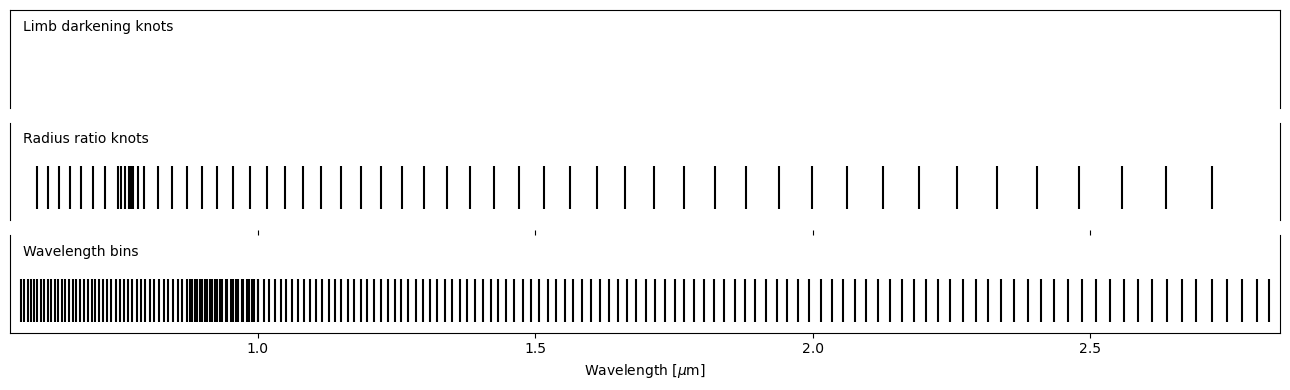

In [17]:
ts.set_radius_ratio_knots(geomspace(ts.data[0].wavelength[5], ts.data[1].wavelength[-5], 50))
ts.add_radius_ratio_knots(linspace(0.768-0.015, 0.768+0.015, 5))
ts.set_radius_ratio_prior('UP', 0.14, 0.15)
ts.plot_setup();

In [18]:
ts.fit_white()

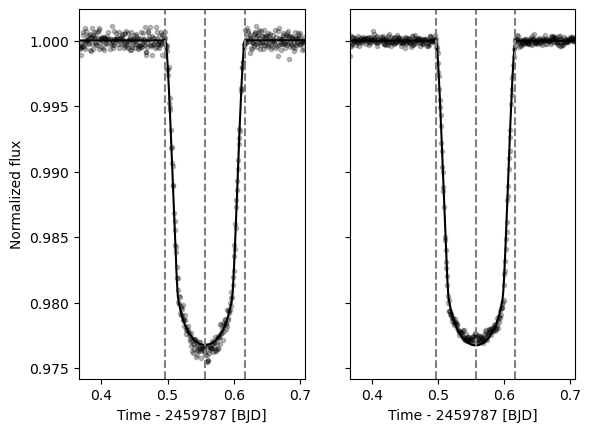

In [19]:
ax = ts.plot_white()

In [21]:
ts.save(overwrite=True)

ValueError: Illegal value: <pytransit.models.ldtkldm.LDTkLD object at 0x71606b9438f0>.

### Set up multiprocessing

Now we're almost ready for fitting and MCMC sampling, but since we're using multiprocessing to parallelise the process, we first need to take some extra steps to make sure everything works the way it's supposed to.

First, we need to define a log-posterior function that calls the `ExoIris` log-posterior method. This must be done so that Python can pickle the method for parallelisation (if you know a better way, please let me know). Next, we also create a multiprocessing pool that will be used by the global optimiser and the MCMC sampler.

In [36]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

### Fit the transmission spectrum

In [44]:
ts.optimizer_population

array([[1.62391142e+00, 2.45969429e+06, 4.05487471e+00, ...,
        1.46042249e-01, 1.46347457e-01, 1.47586737e-01],
       [1.65956261e+00, 2.45969429e+06, 4.05487343e+00, ...,
        1.43282060e-01, 1.46708260e-01, 1.45532426e-01],
       [1.70451134e+00, 2.45969429e+06, 4.05486391e+00, ...,
        1.48476797e-01, 1.46766178e-01, 1.45636021e-01],
       ...,
       [1.64608892e+00, 2.45969429e+06, 4.05487289e+00, ...,
        1.47379053e-01, 1.44879790e-01, 1.47435891e-01],
       [1.59549638e+00, 2.45969429e+06, 4.05487356e+00, ...,
        1.45976007e-01, 1.46393833e-01, 1.46202160e-01],
       [1.71737666e+00, 2.45969429e+06, 4.05487291e+00, ...,
        1.47398687e-01, 1.46289694e-01, 1.45834496e-01]])

Global optimisation:   0%|          | 0/25 [00:00<?, ?it/s]

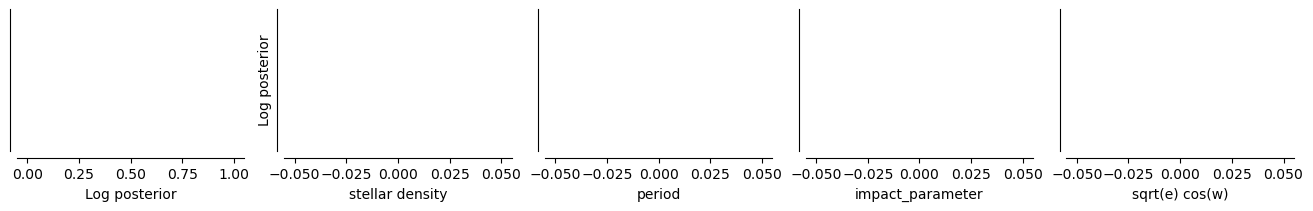

In [37]:
ts.fit(niter=25, npop=250, pool=pool, lnpost=lnpostf)

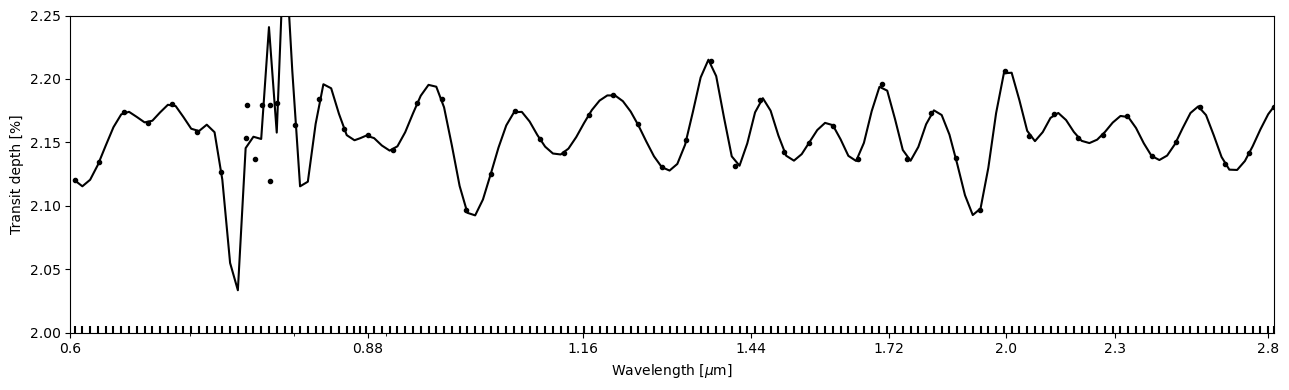

In [42]:
fig, ax = subplots(figsize=(13,4))
ts.plot_transmission_spectrum(result='fit', ax=ax, xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8])
fig.tight_layout()

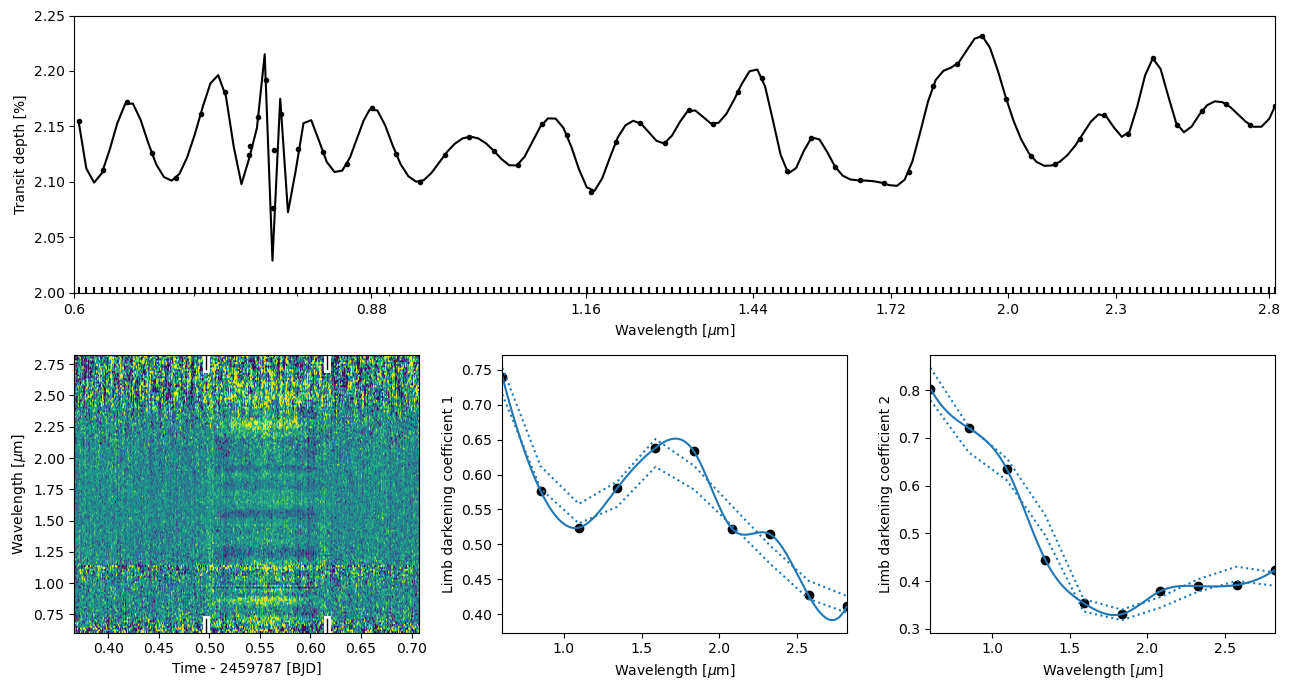

In [28]:
ts.plot_fit(result='fit', figsize=(13,7), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

We can immediately see from the residual plot that the current best-fit solution is bad. This is something we could have guessed already by looking at the log posterior distribution in the optimiser plot that shows a spread of tens of thousands. Let's continue the fitting for another 25 iterations. Each successive `ExoIris.fit` call continues optimisation from the solution of the previous call, and it also plots the old and new posterior and parameter populations at the end of the fit to visualise how the population is changing.

In [29]:
ts._tsa.de.min_ptp = 2

So, it is clear at this stage that running the optimiser for 25 iterations is not doing much. Let's continue the optimisation for 5000 iterations and see if this does the trick. This should take 2-3 min (or less if you initialise the pool with more processes) and the optimisation should finish before it reaches 5000 iterations (the progress bar turns red).

Global optimisation:   0%|          | 0/5000 [00:00<?, ?it/s]

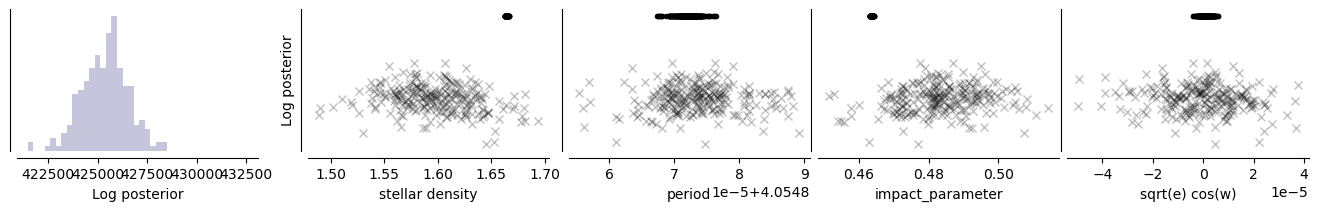

In [30]:
ts.fit(niter=5000, npop=250, pool=pool, lnpost=lnpostf)

Let's plot everything once again. This time, the residuals look good (there's no trace of a transit signal there), the transmission spectrum looks something else than just noise, and the limb darkening parameters also look good, so we're ready to move to the final step: the MCMC sampling.

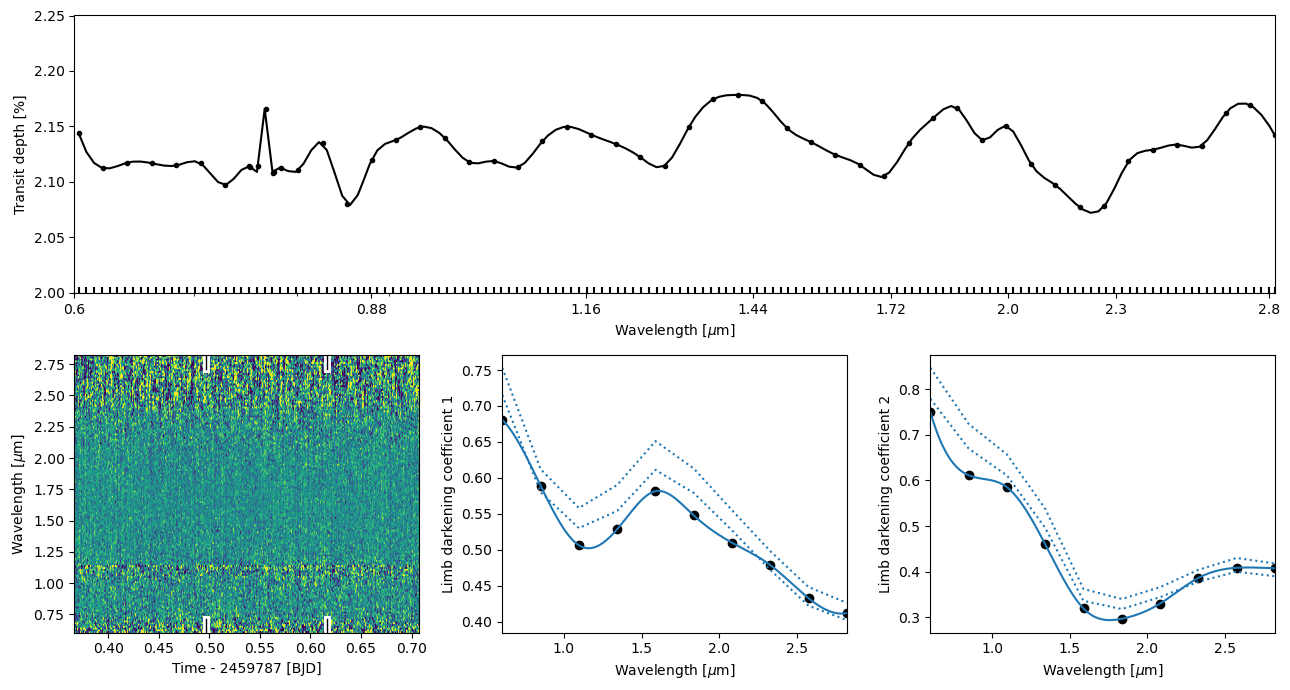

In [32]:
ts.plot_fit(result='fit', figsize=(13,7), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

### Save the optimisation results

In [33]:
ts.save(overwrite=True)

### MCMC sampling

Next comes the final part, obtaining a posterior sample using Markov Chain Monte Carlo (MCMC) sampling. This is done using the `ExoIris.sample` method, that starts with the parameter vector population from the global optimisation. 

As a first step, let's still inflate the limb darkening parameter prior widths by ten to make sure we're not constraining them too much in the sampling phase. So, now we set `uncertainty_multiplier=100` instead of `uncertainty_multiplier=10` that we used in fitting.

In [34]:
#ts.set_ldtk_prior(teff=(5327, 139), logg=(4.38, 0.09), metal=(-0.01, 0.1), uncertainty_multiplier=100)

In [35]:
ts.sample(1000, thin=100, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
df = ts._tsa.posterior_samples()

In [133]:
from numpy.random import normal
sz = ts._tsa._mc_chains[:,:,0].shape
ts._tsa._mc_chains[:, :, 0] += normal(0, 0.05, size=sz)
ts._tsa._mc_chains[:, :, 1] += normal(0, 0.001, size=sz)
ts._tsa._mc_chains[:, :, 3] += normal(0, 0.005, size=sz)
sz = ts._tsa._mc_chains[:,-1,ts._tsa._sl_rratios].shape
ts._tsa._mc_chains[:,-1,ts._tsa._sl_rratios] += normal(0, 1, sz) * 0.002 * ts._tsa._mc_chains[:,-1,ts._tsa._sl_rratios]
sz = ts._tsa._mc_chains[:,-1,ts._tsa._sl_ld].shape
ts._tsa._mc_chains[:,-1,ts._tsa._sl_ld] += normal(0, 1, sz) * 0.002 * ts._tsa._mc_chains[:,-1,ts._tsa._sl_ld]

In [35]:
ts.sample(1000, thin=100, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

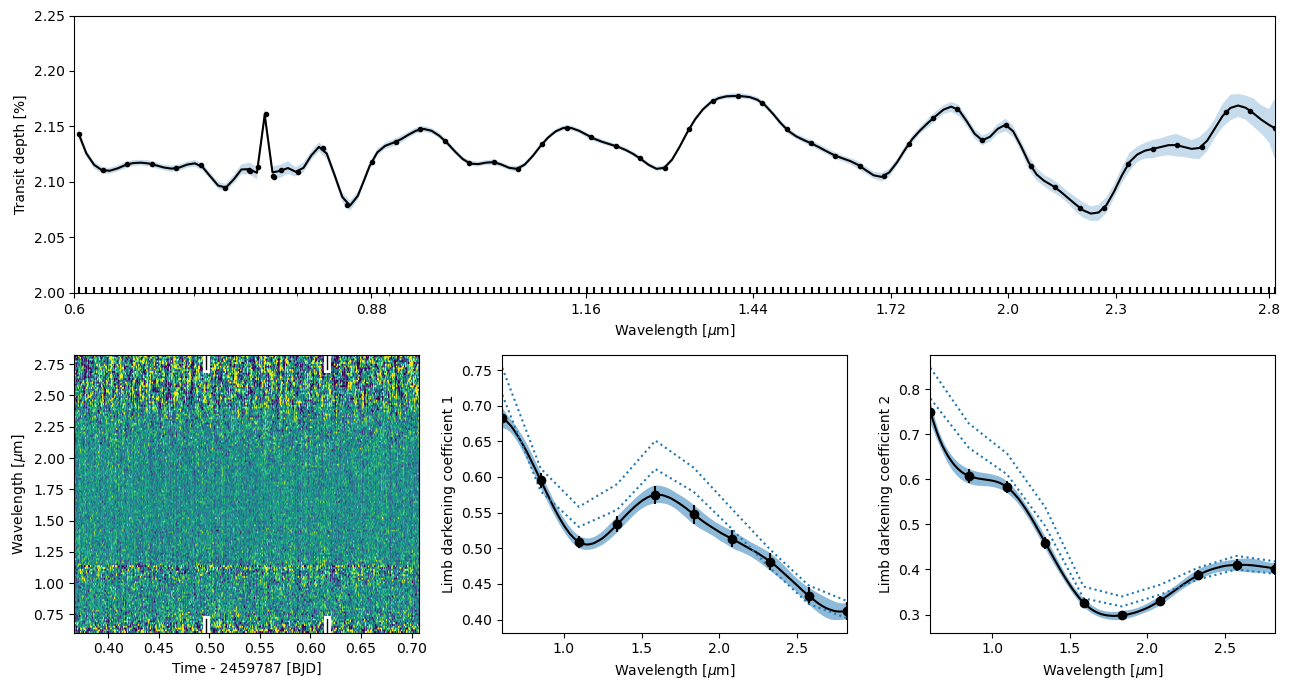

In [36]:
ts.plot_fit(result='mcmc', figsize=(13,7), 
            res_args=dict(pmin=5, pmax=95),
            trs_args=dict(xscale='log', ylim=(2.0,2.25), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

### Save the results and export the transmission spectrum

Congratulations, you now have a low-resolution transmission spectrum for your observations! Let's save the model one more time to also store the posterior samples inside the fits file.

In [37]:
ts.save(overwrite=True)

In [38]:
ts.get_transmission_spectrum()

,depth,depth_e,depth_eneg,depth_epos
wavelength,,,,
0.603338,0.021437,0.000043,-0.000044,0.000042
0.609402,0.021258,0.000029,-0.000028,0.000029
0.615527,0.021155,0.000031,-0.000033,0.000029
0.621713,0.021107,0.000029,-0.000030,0.000028
0.627961,0.021101,0.000027,-0.000027,0.000026
...,...,...,...,...
2.718132,0.021668,0.000110,-0.000109,0.000111
2.745450,0.021617,0.000128,-0.000121,0.000135
2.773042,0.021560,0.000127,-0.000125,0.000130


## How it works????

---

<center>&copy;2024 Hannu Parviainen</center>